In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.5 MB/s eta 0:00:00


In [ ]:
import torch
import time
import random
import copy
import torchmetrics
import numpy as np
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix



Mounted at /content/drive


#Definindo o número de clientes

In [ ]:
num_users = 3
num_classes = 3
epochs = 80
frac = 1
lr = 0.0001
batch_size = 32



SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tesla T4


#Importando o dataset

In [ ]:
data_path='/content/drive/MyDrive/ADNI2'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_path)


# Split dataset into training and testing indices
indices = list(range(len(full_dataset)))
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=SEED, stratify=[full_dataset.targets[i] for i in indices]
)

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

train_dataset = CustomDataset(train_dataset, transform=train_transform)
test_dataset = CustomDataset(test_dataset, transform=test_transform)

labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(class_counts)

Counter({2: 469, 1: 358, 0: 202})


In [ ]:
# Oversampling to balance classes
def oversample_dataset(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    max_count = max(class_counts.values())
    class_to_indices = {cls: [] for cls in np.unique(labels)}
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)

    oversampled_indices = []
    for cls, indices in class_to_indices.items():
        num_to_add = max_count - len(indices)
        if num_to_add > 0:
            indices_to_add = np.random.choice(indices, size=num_to_add, replace=True)
            oversampled_indices.extend(indices)
            oversampled_indices.extend(indices_to_add)
        else:
            oversampled_indices.extend(indices)
    return Subset(dataset, oversampled_indices)

# Apply oversampling
oversampled_train_dataset = oversample_dataset(train_dataset)
train_loader = DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def get_class_distribution(loader):
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.numpy())
    return class_counts

new_train_class_counts = get_class_distribution(train_loader)
print("New class distribution in training loader:", new_train_class_counts)


New class distribution in training loader: Counter({np.int64(0): 469, np.int64(1): 469, np.int64(2): 469})


#Definindo o treinamento dos clientes

In [ ]:
class ResNet50_client_side(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # freeze early layers
        for name, param in resnet.named_parameters():
            if name.startswith(("conv1", "bn1")):
                param.requires_grad = False
        self.features = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1, resnet.layer2
        )
    def forward(self, x):
        return self.features(x)


#Definindo o treinamento do servidor

In [ ]:
class ResNet50_server_side(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(resnet.layer3, resnet.layer4)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        num_ftrs = resnet.fc.in_features
        self.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(num_ftrs, num_classes))
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

class CombinedModel(nn.Module):
    def __init__(self, client_model, server_model):
        super().__init__()
        self.client_model=client_model
        self.server_model=server_model
    def forward(self, x):
        return self.server_model(self.client_model(x))

# Instanciando o modelo do lado do cliente
net_glob_client = ResNet50_client_side()
if torch.cuda.device_count() > 1:
    print("Utilizando", torch.cuda.device_count(), "GPUs")
    net_glob_client = nn.DataParallel(net_glob_client)

net_glob_client.to(device)
print(net_glob_client)

# Instanciando o modelo do lado do servidor
net_glob_server = ResNet50_server_side(num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print("Utilizando", torch.cuda.device_count(), "GPUs")
    net_glob_server = nn.DataParallel(net_glob_server)

net_glob_server.to(device)
print(net_glob_server)

ResNet50_client_side(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [ ]:
loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []
auc_train_collect = []
auc_test_collect = []
batch_acc_train = []
batch_loss_train = []
batch_precision_train = []
batch_recall_train = []
acc_train_collect_user = []
loss_train_collect_user = []
loss_test_collect_user = []
precision_train_collect_user = []
precision_test_collect = []
precision_train_collect = []
recall_test_collect = []
recall_train_collect_user = []
auc_train_collect_user = []
recall_train_collect = []
f1_test_collect = []
batch_auc_train = []
batch_acc_test = []
batch_loss_test = []
batch_prec_test = []
batch_recall_test = []
precision_avg_all_user_train = []
precision_test_collect_user = []
recall_test_collect_user = []
auc_test_collect_user = []
f1_test_collect_user = []
acc_test_collect_user = []


count1 = 0
count2 = 0

In [ ]:
def FedAvgM(w_locals, w_glob_prev, v_prev, beta=0.9):
    # Initialize w_avg
    w_avg = copy.deepcopy(w_locals[0])
    for k in w_avg.keys():
        w_avg[k] = torch.zeros_like(w_avg[k])

    num_clients = len(w_locals)
    for w in w_locals:
        for k in w_avg.keys():
            w_avg[k] += w[k]

    for k in w_avg.keys():
        w_avg[k] = w_avg[k] / num_clients

    # Compute delta_w = w_avg - w_glob_prev
    delta_w = {}
    for k in w_avg.keys():
        delta_w[k] = w_avg[k] - w_glob_prev[k]

    # Update momentum v_t = beta * v_prev + delta_w
    v_t = {}
    for k in delta_w.keys():
        v_t[k] = beta * v_prev[k] + delta_w[k]

    # Update global weights w_glob_new = w_glob_prev + v_t
    w_glob_new = {}
    for k in w_glob_prev.keys():
        w_glob_new[k] = w_glob_prev[k] + v_t[k]

    return w_glob_new, v_t

def calculate_metrics(fx, y, num_classes):
    preds = fx.argmax(dim=1)
    accuracy = torchmetrics.functional.accuracy(preds, y, task='multiclass', num_classes=num_classes)
    precision = torchmetrics.functional.precision(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    recall = torchmetrics.functional.recall(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    f1 = torchmetrics.functional.f1_score(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    auc = torchmetrics.functional.auroc(F.softmax(fx, dim=1), y, task='multiclass', num_classes=num_classes)
    return accuracy, precision, recall, f1, auc

w_glob_server = net_glob_server.state_dict()
w_locals_server = []
weight_decay = 1e-4

idx_collect = []
l_epoch_check = False
fed_check = False

net_model_server = [copy.deepcopy(net_glob_server) for _ in range(num_users)]

net_server = copy.deepcopy(net_model_server[0]).to(device)
optimizer_server = torch.optim.Adam(net_server.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_server = torch.optim.lr_scheduler.StepLR(optimizer_server, step_size=30, gamma=0.1)

beta = 0.9  # Momentum parameter
v_glob_client = {}
w_glob_client = net_glob_client.state_dict()
for k in w_glob_client.keys():
    v_glob_client[k] = torch.zeros_like(w_glob_client[k])

v_glob_server = {}
for k in w_glob_server.keys():
    v_glob_server[k] = torch.zeros_like(w_glob_server[k])


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, save_path='checkpoint.pt'):
        """
        Args:
            patience (int): How many epochs to wait after last validation loss improvement.
            verbose (bool): If True, prints messages about validation loss improvement.
            delta (float): Minimum change in monitored quantity to qualify as improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf  # Initialize with infinity

    def __call__(self, val_loss, models):
        net_glob_client, net_glob_server = models
        score = -val_loss  # Because lower validation loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, net_glob_client, net_glob_server)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, net_glob_client, net_glob_server)
            self.counter = 0

    def save_checkpoint(self, val_loss, net_glob_client, net_glob_server):
        '''Saves models when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving models...')
        torch.save({
            'net_glob_client_state_dict': net_glob_client.state_dict(),
            'net_glob_server_state_dict': net_glob_server.state_dict(),
        }, self.save_path)
        self.val_loss_min = val_loss


In [ ]:
def train_server(fx_client, y, l_epoch_count, l_epoch, idx, len_batch, num_classes=3):
    global net_model_server, criterion, optimizer_server, device
    global batch_acc_train, batch_loss_train, batch_precision_train, batch_recall_train, batch_auc_train
    global l_epoch_check, fed_check, loss_train_collect, acc_train_collect, count1
    global acc_avg_all_user_train, loss_avg_all_user_train, idx_collect, w_locals_server, w_glob_server, net_server
    global loss_train_collect_user, acc_train_collect_user, lr

    net_server = net_model_server[idx].to(device)
    net_server.train()
    optimizer_server = torch.optim.Adam(net_server.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer_server.zero_grad()
    fx_client = fx_client.to(device)
    y = y.to(device)

    fx_server = net_server(fx_client)
    loss = criterion(fx_server, y)
    acc, precision, recall, f1, auc = calculate_metrics(fx_server, y, num_classes)

    loss.backward()
    dfx_client = fx_client.grad.clone().detach()
    optimizer_server.step()

    batch_loss_train.append(loss.item())
    batch_acc_train.append(acc.item())
    batch_precision_train.append(precision.item())
    batch_recall_train.append(recall.item())
    batch_auc_train.append(auc.item())

    net_model_server[idx] = net_server

    count1 += 1
    if count1 == len_batch:
        acc_avg_train = sum(batch_acc_train) / len(batch_acc_train)
        loss_avg_train = sum(batch_loss_train) / len(batch_loss_train)
        precision_avg_train = sum(batch_precision_train) / len(batch_precision_train)
        recall_avg_train = sum(batch_recall_train) / len(batch_recall_train)
        auc_avg_train = sum(batch_auc_train) / len(batch_auc_train)

        batch_acc_train.clear()
        batch_loss_train.clear()
        batch_precision_train.clear()
        batch_recall_train.clear()
        batch_auc_train.clear()
        count1 = 0

        print(f'Client{idx} Train => Local Epoch: {l_epoch_count} \tAcc: {acc_avg_train:.3f} \tLoss: {loss_avg_train:.4f} \tPrecision: {precision_avg_train:.3f} \tRecall: {recall_avg_train:.3f} \tAUC: {auc_avg_train:.3f}')

        w_server = net_server.state_dict()

        if l_epoch_count == l_epoch - 1:
            l_epoch_check = True
            w_locals_server.append(copy.deepcopy(w_server))

            acc_avg_train_all = acc_avg_train
            loss_avg_train_all = loss_avg_train

            loss_train_collect_user.append(loss_avg_train_all)
            acc_train_collect_user.append(acc_avg_train_all)
            precision_train_collect_user.append(precision_avg_train)
            recall_train_collect_user.append(recall_avg_train)
            auc_train_collect_user.append(auc_avg_train)

            if idx not in idx_collect:
                idx_collect.append(idx)

        if len(idx_collect) == num_users:
            fed_check = True
            # Use FedAvgM instead of FedAvg
            global v_glob_server
            w_glob_server, v_glob_server = FedAvgM(w_locals_server, w_glob_server, v_glob_server, beta)
            net_glob_server.load_state_dict(w_glob_server)
            net_model_server = [copy.deepcopy(net_glob_server) for _ in range(num_users)]
            w_locals_server.clear()
            idx_collect.clear()

            acc_avg_all_user_train = sum(acc_train_collect_user) / len(acc_train_collect_user)
            loss_avg_all_user_train = sum(loss_train_collect_user) / len(loss_train_collect_user)
            precision_avg_all_user_train = sum(precision_train_collect_user) / len(precision_train_collect_user)
            recall_avg_all_user_train = sum(recall_train_collect_user) / len(recall_train_collect_user)
            auc_avg_all_user_train = sum(auc_train_collect_user) / len(auc_train_collect_user)

            loss_train_collect.append(loss_avg_all_user_train)
            acc_train_collect.append(acc_avg_all_user_train)
            precision_train_collect.append(precision_avg_all_user_train)
            recall_train_collect.append(recall_avg_all_user_train)
            auc_train_collect.append(auc_avg_all_user_train)

            acc_train_collect_user.clear()
            loss_train_collect_user.clear()
            precision_train_collect_user.clear()
            recall_train_collect_user.clear()
            auc_train_collect_user.clear()

            print(f' Train: Round {l_epoch_count:3d}, Avg Accuracy {acc_avg_all_user_train:.3f} | Avg Loss {loss_avg_all_user_train:.3f} | Precision {precision_avg_all_user_train:.3f} | Recall {recall_avg_all_user_train:.3f} | AUC {auc_avg_all_user_train:.3f}')


    return dfx_client

In [ ]:
def evaluate_server(fx_client, y, idx, len_batch, ell, num_classes=3):
    global net_model_server, criterion, batch_acc_test, batch_loss_test, check_fed, net_server, net_glob_server
    global loss_test_collect, acc_test_collect, count2, num_users, acc_avg_train_all, loss_avg_train_all, w_glob_server, l_epoch_check, fed_check
    global loss_test_collect_user, acc_test_collect_user, acc_avg_all_user_train, loss_avg_all_user_train

    batch_precision_test = []
    acc_test_collect_user = []
    batch_recall_test = []
    batch_auc_test = []
    batch_f1_test = []

    net = copy.deepcopy(net_model_server[idx]).to(device)
    net.eval()

    with torch.no_grad():
        fx_client = fx_client.to(device)
        y = y.to(device)

        fx_server = net(fx_client)
        loss = criterion(fx_server, y)

        acc, precision, recall, f1, auc = calculate_metrics(fx_server, y, num_classes)

        batch_loss_test.append(loss.item())
        batch_acc_test.append(acc.item())
        batch_precision_test.append(precision.item())
        batch_recall_test.append(recall.item())
        batch_auc_test.append(auc.item())
        batch_f1_test.append(f1.item())

        count2 += 1
        if count2 == len_batch:
            acc_avg_test = sum(batch_acc_test) / len(batch_acc_test)
            loss_avg_test = sum(batch_loss_test) / len(batch_loss_test)
            precision_avg_test = sum(batch_precision_test) / len(batch_precision_test)
            recall_avg_test = sum(batch_recall_test) / len(batch_recall_test)
            auc_avg_test = sum(batch_auc_test) / len(batch_auc_test)
            f1_avg_test = sum(batch_f1_test) / len(batch_f1_test)

            batch_acc_test = []
            batch_loss_test = []
            batch_precision_test = []
            batch_recall_test = []
            batch_auc_test = []
            batch_f1_test = []
            count2 = 0

            print('Client{} Test =>                   \tAcc: {:.3f} \tLoss: {:.4f} \tPrecision: {:.3f} \tRecall: {:.3f} \tAUC: {:.3f} \tF1-Score: {:.3f}'.format(
                idx, acc_avg_test, loss_avg_test, precision_avg_test, recall_avg_test, auc_avg_test, f1_avg_test))

            if l_epoch_check:
                l_epoch_check = False

                acc_avg_test_all = acc_avg_test
                loss_avg_test_all = loss_avg_test

                loss_test_collect_user.append(loss_avg_test_all)
                acc_test_collect_user.append(acc_avg_test_all)

            if fed_check:
                fed_check = False
                print("------------------------------------------------")
                print("------ Federation process at Server-Side ------- ")
                print("------------------------------------------------")

                # **Append the missing test metrics to their respective lists**
                precision_test_collect_user.append(precision_avg_test)
                recall_test_collect_user.append(recall_avg_test)
                auc_test_collect_user.append(auc_avg_test)
                f1_test_collect_user.append(f1_avg_test)

                # Compute averages with conditional expressions
                acc_avg_all_user = sum(acc_test_collect_user) / len(acc_test_collect_user) if len(acc_test_collect_user) > 0 else 0
                loss_avg_all_user = sum(loss_test_collect_user) / len(loss_test_collect_user) if len(loss_test_collect_user) > 0 else 0
                precision_avg_all_user = sum(precision_test_collect_user) / len(precision_test_collect_user) if len(precision_test_collect_user) > 0 else 0
                recall_avg_all_user = sum(recall_test_collect_user) / len(recall_test_collect_user) if len(recall_test_collect_user) > 0 else 0
                auc_avg_all_user = sum(auc_test_collect_user) / len(auc_test_collect_user) if len(auc_test_collect_user) > 0 else 0
                f1_avg_all_user = sum(f1_test_collect_user) / len(f1_test_collect_user) if len(f1_test_collect_user) > 0 else 0

                loss_test_collect.append(loss_avg_all_user)
                acc_test_collect.append(acc_avg_all_user)
                precision_test_collect.append(precision_avg_all_user)
                recall_test_collect.append(recall_avg_all_user)
                auc_test_collect.append(auc_avg_all_user)
                f1_test_collect.append(f1_avg_all_user)

                acc_test_collect_user.clear()
                loss_test_collect_user.clear()
                precision_test_collect_user.clear()
                recall_test_collect_user.clear()
                auc_test_collect_user.clear()
                f1_test_collect_user.clear()

                # **Compute averages for training metrics**
                # acc_avg_all_user_train = sum(acc_train_collect_user) / len(acc_train_collect_user)
                # loss_avg_all_user_train = sum(loss_train_collect_user) / len(loss_train_collect_user)
                # precision_avg_all_user_train = sum(precision_train_collect_user) / len(precision_train_collect_user)
                # recall_avg_all_user_train = sum(recall_train_collect_user) / len(recall_train_collect_user)
                # auc_avg_all_user_train = sum(auc_train_collect_user) / len(auc_train_collect_user)

                print("====================== SERVER V1==========================")
                #print(f' Train: Round {ell:3d}, Avg Accuracy {acc_avg_all_user_train:.3f} | Avg Loss {loss_avg_all_user_train:.3f} | Precision {precision_avg_all_user_train:.3f} | Recall {recall_avg_all_user_train:.3f} | AUC {auc_avg_all_user_train:.3f}')
                print(f' Test:  Round {ell:3d}, Avg Accuracy {acc_avg_all_user:.3f} | Avg Loss {loss_avg_all_user:.3f} | Precision {precision_avg_all_user:.3f} | Recall {recall_avg_all_user:.3f} | AUC {auc_avg_all_user:.3f} | F1-Score {f1_avg_all_user:.3f}')
                print("==========================================================")

    return


In [ ]:
def evaluate_accuracy(net, loader, device, return_conf_matrix=False, num_classes=3):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    accuracy = torchmetrics.functional.accuracy(all_preds, all_labels, task='multiclass', num_classes=num_classes).item()
    precision = torchmetrics.functional.precision(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    recall = torchmetrics.functional.recall(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    f1 = torchmetrics.functional.f1_score(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    auc = torchmetrics.functional.auroc(F.softmax(outputs, dim=1), all_labels, task='multiclass', num_classes=num_classes).item()

    conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

    if return_conf_matrix:
        return accuracy, precision, recall, f1, auc, conf_matrix
    else:
        return accuracy, precision, recall, f1, auc

class DatasetSplit(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, label = self.dataset[real_idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class Client(object):
    def __init__(self, net_client_model, idx, lr, device, train_loader=None, test_loader=None, idxs=None, idxs_test=None):
        self.idx = idx
        self.device = device
        self.lr = lr
        self.local_ep = 1
        self.train_dataset = DatasetSplit(full_dataset, idxs, transform=train_transform)  # Use 'idxs' for training
        self.test_dataset = DatasetSplit(full_dataset, idxs_test, transform=test_transform)  # Use 'idxs_test' for testing
        self.ldr_train = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.ldr_test = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        self.net_client_model = copy.deepcopy(net_client_model)

    def train(self, net):
        net.train()
        self.net_client_model.to(self.device)
        optimizer_client = torch.optim.Adam(net.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer_client, step_size=30, gamma=0.1)

        for iter in range(self.local_ep):
            len_batch = len(self.ldr_train)

            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer_client.zero_grad()
                fx = net(images)
                client_fx = fx.clone().detach().requires_grad_(True)
                dfx = train_server(client_fx, labels, iter, self.local_ep, self.idx, len_batch)
                fx.backward(dfx)

                # Remove FedProx proximal term
                # for param_local, param_global in zip(net.parameters(), self.net_client_model.parameters()):
                #     if param_local.grad is not None:
                #         param_local.grad += self.mu * (param_local.data - param_global.data)

                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer_client.step()

            scheduler.step()

        return net.state_dict()

    def evaluate(self, net, ell, num_classes=3):
        net.eval()

        with torch.no_grad():
            len_batch = len(self.ldr_test)
            for batch_idx, (images, labels) in enumerate(self.ldr_test):
                images, labels = images.to(self.device), labels.to(self.device)
                fx = net(images)
                evaluate_server(fx, labels, self.idx, len_batch, ell, num_classes)

        return

def dataset_iid(indices, num_users):
    indices = np.array(indices)
    num_items_per_user = len(indices) // num_users
    dict_users = {}
    for i in range(num_users):
        start_idx = i * num_items_per_user
        end_idx = (i + 1) * num_items_per_user if i != num_users - 1 else len(indices)
        dict_users[i] = indices[start_idx:end_idx]
    return dict_users

##Treino!


In [ ]:
epoch_times = []

dict_users = dataset_iid(train_indices, num_users)
dict_users_test = dataset_iid(test_indices, num_users)
net_glob_client.train()

early_stopping = EarlyStopping(patience=80, verbose=True, save_path='best_model.pt')

w_glob_client = net_glob_client.state_dict()

for iter in range(epochs):
    start_time = time.time()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)
    w_locals_client = []

    for idx in idxs_users:
        local = Client(
            net_glob_client,
            idx,
            lr,
            device,
            idxs=dict_users[idx],
            idxs_test=dict_users_test[idx]
        )

        w_client = local.train(net=copy.deepcopy(net_glob_client).to(device))
        w_locals_client.append(copy.deepcopy(w_client))

        local.evaluate(net=copy.deepcopy(net_glob_client).to(device), ell=iter)

    print("-----------------------------------------------------------")
    print("------ FedServer: Federation process at Client-Side ------- ")
    print("-----------------------------------------------------------")

    # Use FedAvgM instead of FedAvg
    w_glob_client, v_glob_client = FedAvgM(w_locals_client, w_glob_client, v_glob_client, beta)
    net_glob_client.load_state_dict(w_glob_client)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {iter + 1}/{epochs} - Time taken: {epoch_time:.2f} seconds")

    # Early stopping check
    if len(loss_test_collect) > 0:
        val_loss = loss_test_collect[-1]
        early_stopping(val_loss, (net_glob_client, net_glob_server))
        if early_stopping.early_stop:
            print("Early stopping")
            break
    else:
        print("No validation loss collected yet.")

print("Training and Evaluation completed!")

# Load the best model after training
checkpoint = torch.load('best_model.pt', weights_only=True)
net_glob_client.load_state_dict(checkpoint['net_glob_client_state_dict'])
net_glob_server.load_state_dict(checkpoint['net_glob_server_state_dict'])

Client0 Train => Local Epoch: 0 	Acc: 0.380 	Loss: 1.0984 	Precision: 0.381 	Recall: 0.357 	AUC: 0.538
Client0 Test =>                   	Acc: 0.402 	Loss: 1.1038 	Precision: 0.321 	Recall: 0.314 	AUC: 0.404 	F1-Score: 0.306


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Client2 Train => Local Epoch: 0 	Acc: 0.413 	Loss: 1.0882 	Precision: 0.374 	Recall: 0.367 	AUC: 0.542
Client2 Test =>                   	Acc: 0.454 	Loss: 1.0986 	Precision: 0.315 	Recall: 0.370 	AUC: 0.492 	F1-Score: 0.300
Client1 Train => Local Epoch: 0 	Acc: 0.319 	Loss: 1.0996 	Precision: 0.345 	Recall: 0.340 	AUC: 0.529
 Train: Round   0, Avg Accuracy 0.371 | Avg Loss 1.095 | Precision 0.367 | Recall 0.355 | AUC 0.537
Client1 Test =>                   	Acc: 0.387 	Loss: 1.1016 	Precision: 0.229 	Recall: 0.287 	AUC: 0.437 	F1-Score: 0.216
------------------------------------------------
------ Federation process at Server-Side ------- 
------------------------------------------------
====================== SERVER V1==========================
 Test:  Round   0, Avg Accuracy 0.387 | Avg Loss 1.101 | Precision 0.229 | Recall 0.287 | AUC 0.437 | F1-Score 0.216
-----------------------------------------------------------
------ FedServer: Federation process at Client-Side ------- 
-----

<All keys matched successfully>

Could not plot accuracy: [Errno 2] No such file or directory: '/mnt/data/accuracy_styled.png'


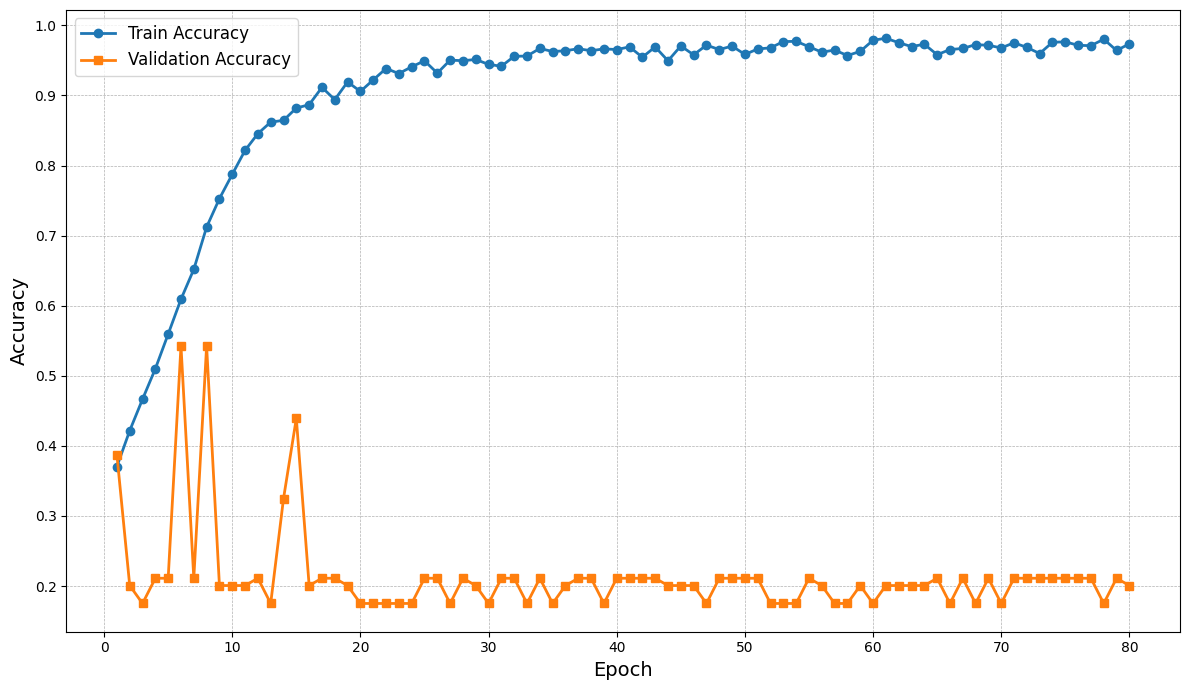

In [ ]:
import matplotlib.pyplot as plt

# --- Styled Accuracy plot (Train vs. Validation) ---
try:
    n = min(len(acc_train_collect), len(acc_test_collect))
    if n == 0:
        raise ValueError('Accuracy lists are empty. Run training before plotting.')
    x = list(range(1, n + 1))
    plt.figure(figsize=(12, 7))
    plt.plot(x, acc_train_collect[:n], marker='o', linewidth=2, markersize=6, label='Train Accuracy')
    plt.plot(x, acc_test_collect[:n], marker='s', linewidth=2, markersize=6, label='Validation Accuracy')
    # Title tries to include number of clients if available
    num_clients = None
    # title = 'Accuracy over Epochs' + (f' ({num_clients} Clients)' if num_clients else '')
    # plt.title(title, fontsize=18, pad=12)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('/mnt/data/accuracy_styled.png', dpi=150)
    plt.show()
    print('Saved figure to /mnt/data/accuracy_styled.png')
except Exception as e:
    print(f'Could not plot accuracy: {e}')
